In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.calibration import calibration_curve


In [21]:
# Load dataset
columns = [
    "ID", "Clump_Thickness", "Uniformity_Cell_Size", "Uniformity_Cell_Shape",
    "Marginal_Adhesion", "Single_Epithelial_Cell_Size", "Bare_Nuclei",
    "Bland_Chromatin", "Normal_Nucleoli", "Mitoses", "Class"
]
df = pd.read_csv("breast-cancer-wisconsin.data", names=columns, header=None)
df.head(10)  # Display first 10 rows


,ID,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


In [33]:
# Inspect metadata
with open("breast-cancer-wisconsin.names", "r") as f:
    meta_info = f.read()
print(meta_info[:500])


Citation Request:
   This breast cancer databases was obtained from the University of Wisconsin
   Hospitals, Madison from Dr. William H. Wolberg.  If you publish results
   when using this database, then please include this information in your
   acknowledgements.  Also, please cite one or more of:

   1. O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear 
      programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.

   2. William H. Wolberg and O.L. Mangasarian


In [34]:
# Replace missing values
df.replace("?", np.nan, inplace=True)
df.dropna(inplace=True)

# Convert columns to numeric
for col in df.columns:
    if col != "ID":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Map target: 2=benign (0), 4=malignant (1)
df["Class"] = df["Class"].map({2: 0, 4: 1})

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 683 entries, 0 to 698
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           683 non-null    int64  
 1   Clump_Thickness              683 non-null    int64  
 2   Uniformity_Cell_Size         683 non-null    int64  
 3   Uniformity_Cell_Shape        683 non-null    int64  
 4   Marginal_Adhesion            683 non-null    int64  
 5   Single_Epithelial_Cell_Size  683 non-null    int64  
 6   Bare_Nuclei                  683 non-null    int64  
 7   Bland_Chromatin              683 non-null    int64  
 8   Normal_Nucleoli              683 non-null    int64  
 9   Mitoses                      683 non-null    int64  
 10  Class                        0 non-null      float64
 11  Size_to_Shape                683 non-null    float64
 12  Nuclei_to_Chromatin          683 non-null    float64
 13  Cell_Complexity          

In [35]:
# EDA (exploratory data analysis)
print("Class distribution:\n", df["Class"].value_counts())
print("\nSummary stats:\n", df.drop(columns=["ID", "Class"]).describe())


Class distribution:
 Series([], Name: count, dtype: int64)

Summary stats:
        Clump_Thickness  Uniformity_Cell_Size  Uniformity_Cell_Shape  \
count       683.000000            683.000000             683.000000   
mean          4.442167              3.150805               3.215227   
std           2.820761              3.065145               2.988581   
min           1.000000              1.000000               1.000000   
25%           2.000000              1.000000               1.000000   
50%           4.000000              1.000000               1.000000   
75%           6.000000              5.000000               5.000000   
max          10.000000             10.000000              10.000000   

       Marginal_Adhesion  Single_Epithelial_Cell_Size  Bare_Nuclei  \
count         683.000000                   683.000000   683.000000   
mean            2.830161                     3.234261     3.544656   
std             2.864562                     2.223085     3.643857   
min 

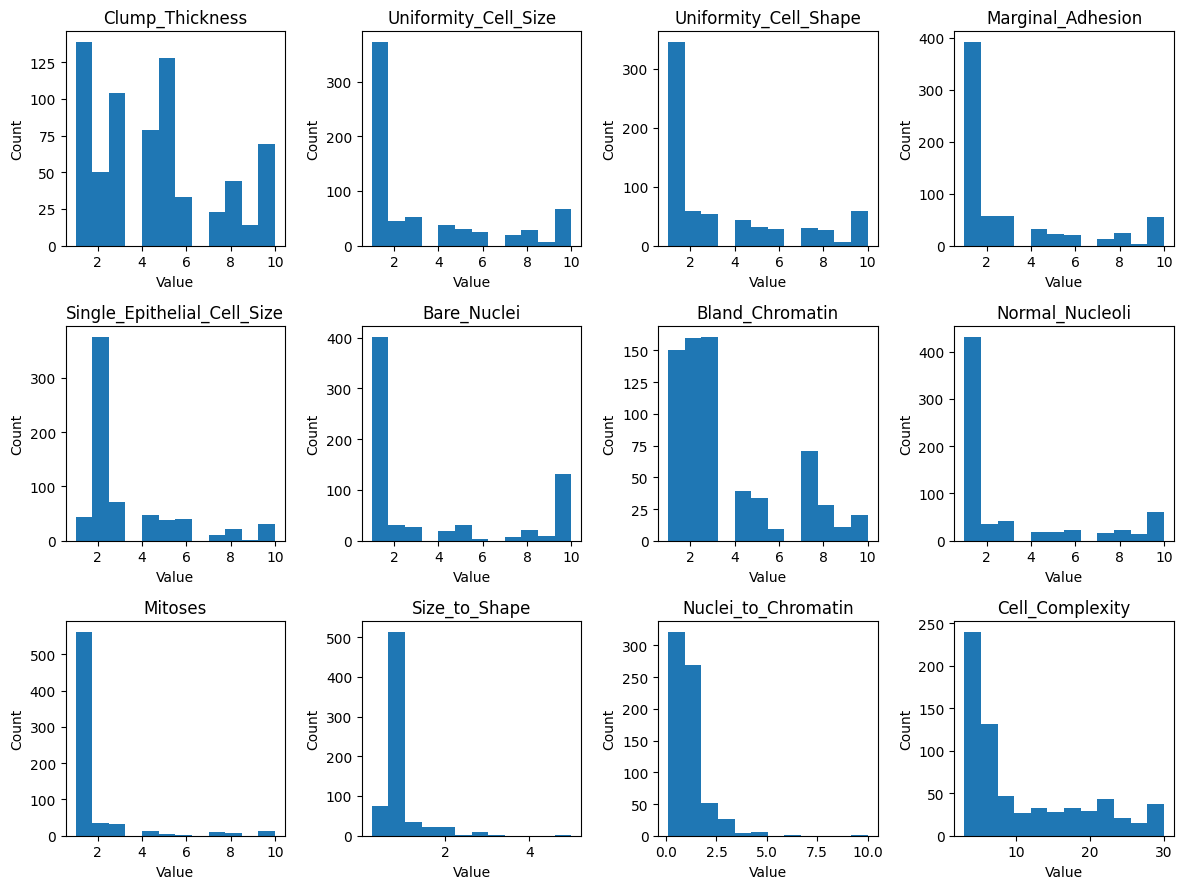

In [36]:
# Histograms for each feature
features = df.drop(columns=["ID", "Class"]).columns.tolist()
n_features = len(features)
cols = 4
rows = int(np.ceil(n_features / cols))

plt.figure(figsize=(12, rows * 3))
for i, feat in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    plt.hist(df[feat], bins=12)
    plt.title(feat)
    plt.xlabel("Value")
    plt.ylabel("Count")
plt.tight_layout()
plt.show()


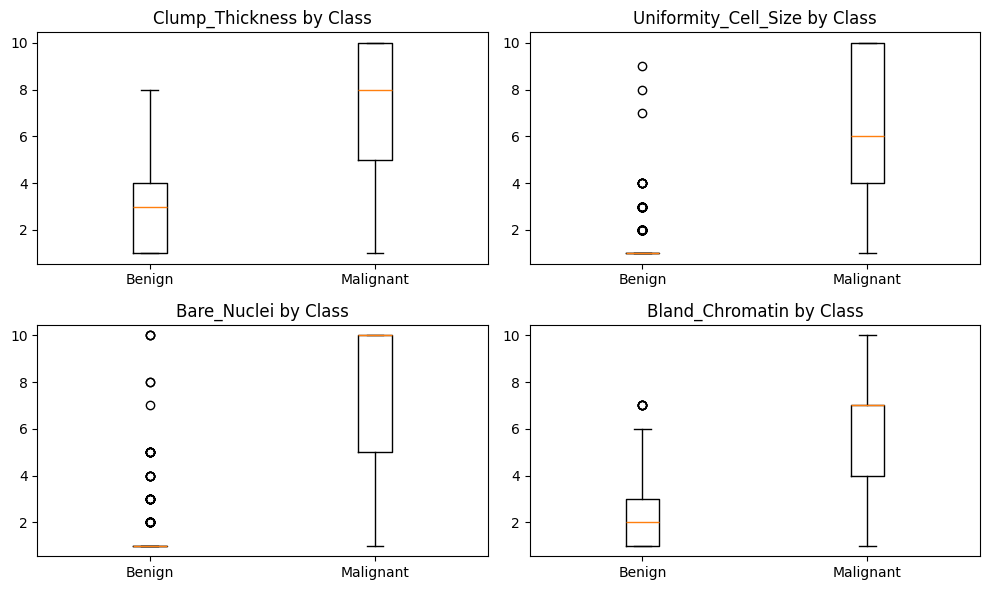

In [26]:
# Boxplots for a few informative features comparing classes
selected = ["Clump_Thickness", "Uniformity_Cell_Size", "Bare_Nuclei", "Bland_Chromatin"]
plt.figure(figsize=(10, 6))
for i, feat in enumerate(selected, 1):
    plt.subplot(2, 2, i)
    data_to_plot = [df[df["Class"] == cls][feat] for cls in sorted(df["Class"].unique())]
    plt.boxplot(data_to_plot, tick_labels=["Benign", "Malignant"])
    plt.title(feat + " by Class")
plt.tight_layout()
plt.show() 



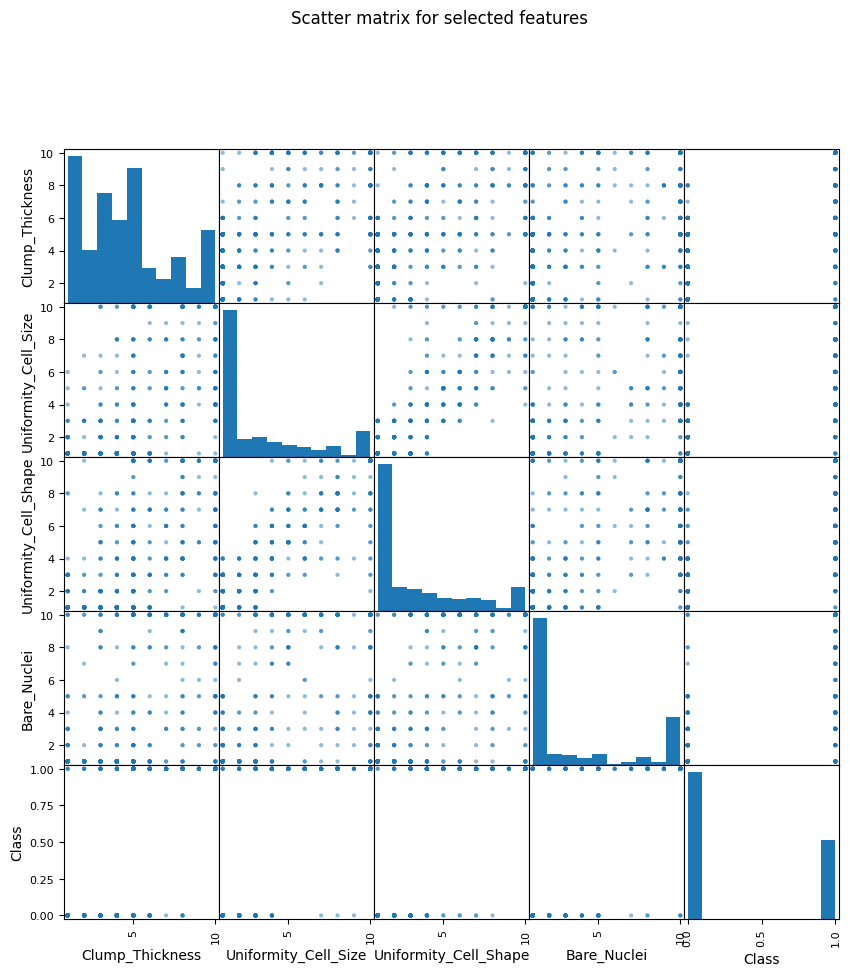

In [27]:
# scatter matrix for a subset
subset = ["Clump_Thickness", "Uniformity_Cell_Size", "Uniformity_Cell_Shape", "Bare_Nuclei", "Class"]
pd.plotting.scatter_matrix(df[subset], figsize=(10, 10), diagonal="hist")
plt.suptitle("Scatter matrix for selected features", y=1.02)
plt.show()


In [28]:
# Feature engineering (composite features)
df["Size_to_Shape"] = df["Uniformity_Cell_Size"] / (df["Uniformity_Cell_Shape"] + 1e-6)
df["Nuclei_to_Chromatin"] = df["Bare_Nuclei"] / (df["Bland_Chromatin"] + 1e-6)
df["Cell_Complexity"] = df["Uniformity_Cell_Size"] + df["Uniformity_Cell_Shape"] + df["Clump_Thickness"]


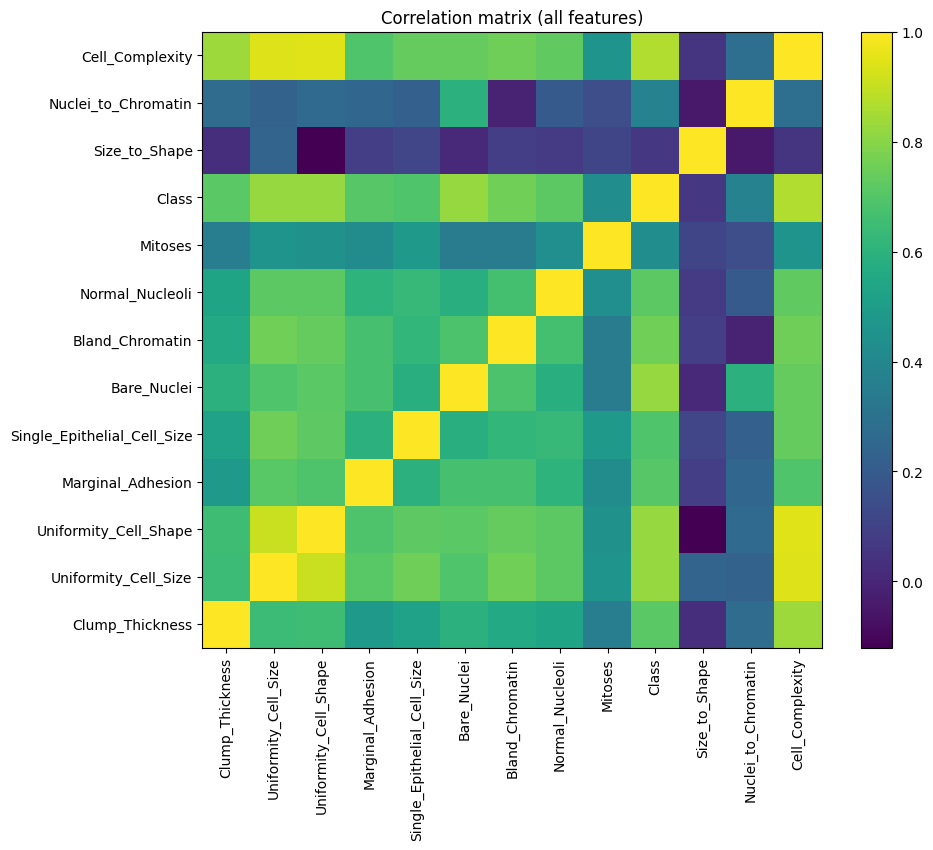

In [29]:
# Correlation matrix visualization
corr = df.drop(columns=["ID"]).corr()
plt.figure(figsize=(10, 8))
plt.pcolor(corr)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns, rotation=90)
plt.yticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
plt.title("Correlation matrix (all features)")
plt.colorbar()
plt.show()


In [30]:
# feature reduction PCA & RFE
X = df.drop(columns=["ID", "Class"])
y = df["Class"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA. pick a small number of components for demonstration
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
print("PCA explained variance ratio (first 5):", pca.explained_variance_ratio_)

# RFE with RandomForest as the estimator
rf_for_rfe = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf_for_rfe, n_features_to_select=6)
rfe.fit(X_scaled, y)
selected_features_rfe = X.columns[rfe.get_support()].tolist()
print("RFE selected features:", selected_features_rfe)
X_rfe = X[selected_features_rfe]
X_rfe_scaled = scaler.fit_transform(X_rfe)


PCA explained variance ratio (first 5): [0.57668682 0.10229976 0.08416897 0.06313037 0.0485527 ]
RFE selected features: ['Uniformity_Cell_Size', 'Uniformity_Cell_Shape', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin', 'Cell_Complexity']


In [31]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


In [32]:
#models
models = {
    "Naive Bayes": GaussianNB(),
    "kNN_k3": KNeighborsClassifier(n_neighbors=3),
    "kNN_k5": KNeighborsClassifier(n_neighbors=5),
    "kNN_k7": KNeighborsClassifier(n_neighbors=7),
    "Bagging_kNN": BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=5), n_estimators=20, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}


In [14]:
# Cross-validated evaluation (5-fold for speed/stability)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_metrics(model, X_data, y_data, cv=cv):
    return {
        "accuracy": cross_val_score(model, X_data, y_data, cv=cv, scoring="accuracy").mean(),
        "precision": cross_val_score(model, X_data, y_data, cv=cv, scoring="precision").mean(),
        "recall": cross_val_score(model, X_data, y_data, cv=cv, scoring="recall").mean(),
        "f1": cross_val_score(model, X_data, y_data, cv=cv, scoring="f1").mean(),
        "roc_auc": cross_val_score(model, X_data, y_data, cv=cv, scoring="roc_auc").mean()
    }

# run cv on full, PCA and RFE feature sets (reduced compute)
cv_results = {"full": {}, "pca": {}, "rfe": {}}
for name, model in models.items():
    cv_results["full"][name] = cv_metrics(model, X_scaled, y)
    cv_results["pca"][name] = cv_metrics(model, X_pca, y)
    cv_results["rfe"][name] = cv_metrics(model, X_rfe_scaled, y)

# print summary for full features
for name, res in cv_results["full"].items():
    print(f"{name}: Acc={res['accuracy']:.3f}, Prec={res['precision']:.3f}, Rec={res['recall']:.3f}, F1={res['f1']:.3f}, AUC={res['roc_auc']:.3f}")


Naive Bayes: Acc=0.960, Prec=0.918, Rec=0.975, F1=0.945, AUC=0.988
kNN_k3: Acc=0.965, Prec=0.957, Rec=0.941, F1=0.949, AUC=0.985
kNN_k5: Acc=0.969, Prec=0.966, Rec=0.946, F1=0.955, AUC=0.985
kNN_k7: Acc=0.971, Prec=0.962, Rec=0.954, F1=0.958, AUC=0.985
Bagging_kNN: Acc=0.968, Prec=0.966, Rec=0.941, F1=0.953, AUC=0.991
RandomForest: Acc=0.972, Prec=0.948, Rec=0.975, F1=0.961, AUC=0.992


Test [Naive Bayes] Acc=0.964, Prec=0.922, Rec=0.979, F1=0.949
Test [kNN_k3] Acc=0.956, Prec=0.920, Rec=0.958, F1=0.939
Test [kNN_k5] Acc=0.956, Prec=0.920, Rec=0.958, F1=0.939
Test [kNN_k7] Acc=0.956, Prec=0.920, Rec=0.958, F1=0.939
Test [Bagging_kNN] Acc=0.956, Prec=0.920, Rec=0.958, F1=0.939
Test [RandomForest] Acc=0.956, Prec=0.920, Rec=0.958, F1=0.939


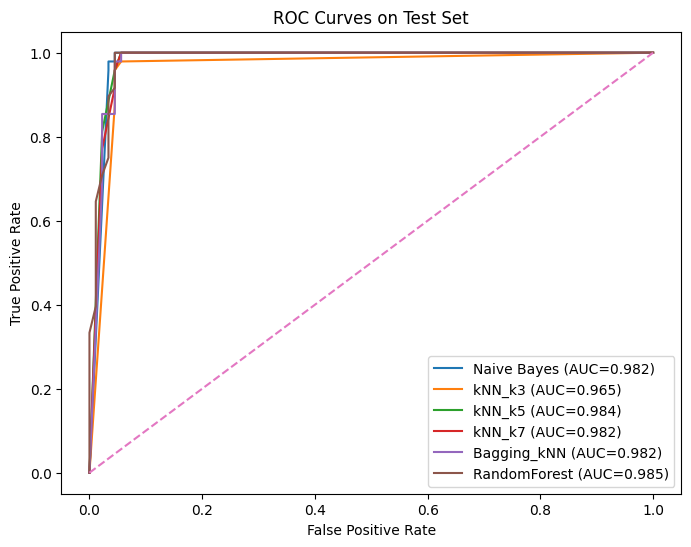

In [15]:
# Train on train set and evaluate on test set; plot ROC curves
plt.figure(figsize=(8, 6))
for name, model in models.items():
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Test [{name}] Acc={accuracy_score(y_test, y_pred):.3f}, Prec={precision_score(y_test, y_pred):.3f}, Rec={recall_score(y_test, y_pred):.3f}, F1={f1_score(y_test, y_pred):.3f}")
    if hasattr(clf, "predict_proba"):
        probs = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, probs)
        auc = roc_auc_score(y_test, probs)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves on Test Set")
plt.legend(loc="lower right")
plt.show()


In [16]:
# Confusion matrix example for RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Confusion matrix for RandomForest on test set:\n", confusion_matrix(y_test, rf.predict(X_test)))


Confusion matrix for RandomForest on test set:
 [[85  4]
 [ 2 46]]


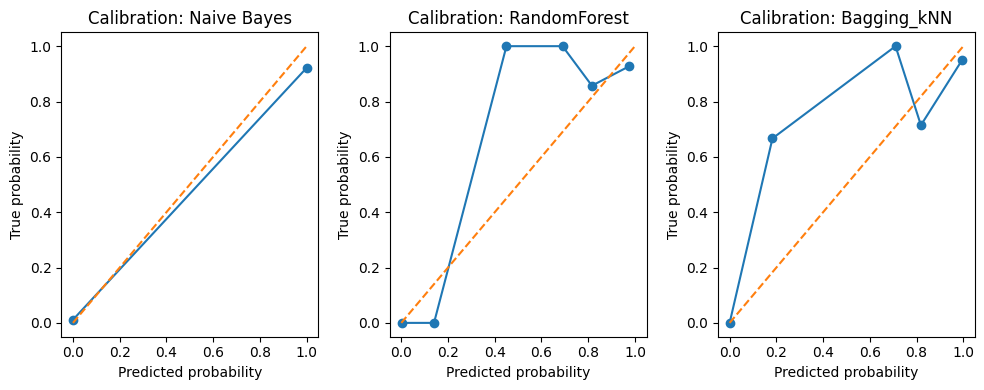

In [17]:
# calibration plots for probabilistic models
plt.figure(figsize=(10, 4))
for i, name in enumerate(["Naive Bayes", "RandomForest", "Bagging_kNN"], 1):
    clf = models[name]
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
        prob_true, prob_pred = calibration_curve(y_test, prob_pos, n_bins=8)
        plt.subplot(1, 3, i)
        plt.plot(prob_pred, prob_true, marker='o')
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.title(f"Calibration: {name}")
        plt.xlabel("Predicted probability")
        plt.ylabel("True probability")
    else:
        plt.subplot(1, 3, i)
        plt.text(0.5, 0.5, f"No prob. for {name}", horizontalalignment='center')
plt.tight_layout()
plt.show()


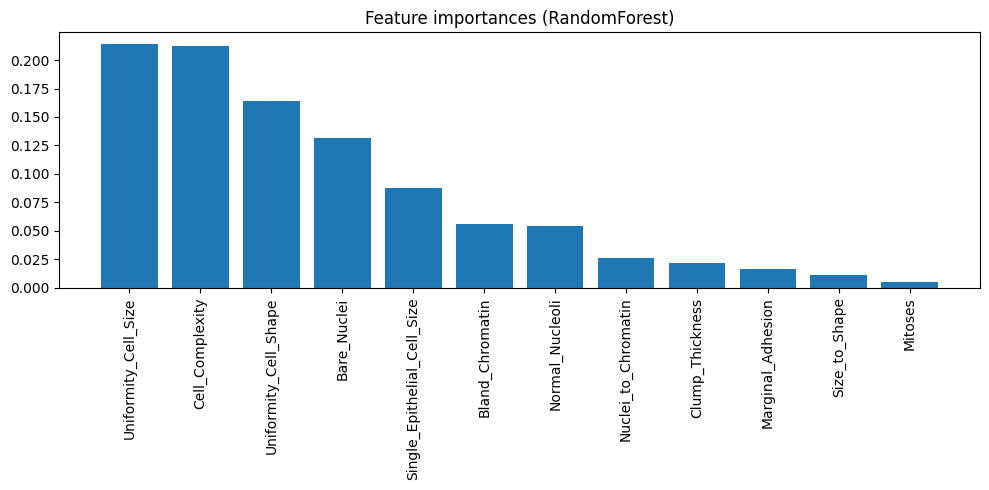

In [18]:
# Feature importances from RandomForest (helpful visualization)
rf_full = RandomForestClassifier(n_estimators=100, random_state=42)
rf_full.fit(X_scaled, y)
imp = rf_full.feature_importances_
names = X.columns.tolist()
idx_sorted = np.argsort(imp)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(imp)), imp[idx_sorted])
plt.xticks(range(len(imp)), [names[i] for i in idx_sorted], rotation=90)
plt.title("Feature importances (RandomForest)")
plt.tight_layout()
plt.show()


In [19]:
# Save CV summary for inspection
summary_df = pd.concat({
    'full': pd.DataFrame(cv_results['full']).T,
    'pca': pd.DataFrame(cv_results['pca']).T,
    'rfe': pd.DataFrame(cv_results['rfe']).T
}, axis=0)

summary_df.to_csv("model_cv_summary_reduced.csv")
print("Saved CV summary to model_cv_summary_reduced.csv")


Saved CV summary to model_cv_summary_reduced.csv


In [20]:
#Ethical discussions.
print("\nEthical discussion:")
print("* Reducing features risks removing clinically important signals; involve domain experts before feature removal.")
print("* False negatives are dangerous: in cancer screening high recall (sensitivity) is often prioritized.")
print("* PCA reduces interpretability — in clinical contexts, prefer explainable models or post-hoc explanations.")
print("* Proper calibration of probabilities matters for clinical decision thresholds.")
print("* Dataset bias must be checked; models trained on non-representative samples may generalize poorly.")



Ethical discussion:
* Reducing features risks removing clinically important signals; involve domain experts before feature removal.
* False negatives are dangerous: in cancer screening high recall (sensitivity) is often prioritized.
* PCA reduces interpretability — in clinical contexts, prefer explainable models or post-hoc explanations.
* Proper calibration of probabilities matters for clinical decision thresholds.
* Dataset bias must be checked; models trained on non-representative samples may generalize poorly.
